In [1]:
import tensorflow as tf
import os
import random
import numpy as np

import glob
import cv2 
from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

seed = 45
np.random.seed=seed

In [9]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
n_classes=10


#Build the model
inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s=inputs

    #Contraction path
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
     
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
     
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
     
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
outputs = tf.keras.layers.Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    
    #NOTE: Compile the model in the main program to make it easy to test with various loss functions
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 1)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_19 (Conv2D)            │ (None, 128, 128, 16)      │             160 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 128, 128, 16)      │               0 │ conv2d_19[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_20 (Conv2D)            │ (None, 128, 128, 16)      │           2,320 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_4               │ (None, 64, 64, 16)        │               0 │ conv2d_20[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_21 (Conv2D)            │ (None, 64, 64, 32)        │           4,640 │ max_pooling2d_4[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_10 (Dropout)          │ (None, 64, 64, 32)        │               0 │ conv2d_21[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_22 (Conv2D)            │ (None, 64, 64, 32)        │           9,248 │ dropout_10[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_5               │ (None, 32, 32, 32)        │               0 │ conv2d_22[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_23 (Conv2D)            │ (None, 32, 32, 64)        │          18,496 │ max_pooling2d_5[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_11 (Dropout)          │ (None, 32, 32, 64)        │               0 │ conv2d_23[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_24 (Conv2D)            │ (None, 32, 32, 64)        │          36,928 │ dropout_11[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_6               │ (None, 16, 16, 64)        │               0 │ conv2d_24[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_25 (Conv2D)            │ (None, 16, 16, 128)       │          73,856 │ max_pooling2d_6[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_12 (Dropout)          │ (None, 16, 16, 128)       │               0 │ conv2d_25[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_26 (Conv2D)            │ (None, 16, 16, 128)       │         147,58

 Total params: 1,940,970 (7.40 MB)

 Trainable params: 1,940,970 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Define paths and parameters
DATASET_PATH = 'imgs/'
sub_dirs = next(os.walk(DATASET_PATH))[1]
SIZE_X = 128
SIZE_Y = 128
n_classes = 10  # Number of classes for segmentation

# Capture training image info as a list
train_images = []
train_masks = []

print('Resizing training images and masks')
for sub_dir in tqdm(sub_dirs, total=len(sub_dirs)):   
    path = os.path.join(DATASET_PATH, sub_dir)
    
    # Load image
    img_path = os.path.join(path, 'source.jpg')
    img = cv2.imread(img_path, 0)  # Read as grayscale
    img = cv2.resize(img, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_AREA)
    train_images.append(img)
    
    # Load mask
    mask_path = os.path.join(path, 'mask.png')
    mask = cv2.imread(mask_path, 0)  # Read as grayscale
    mask = cv2.resize(mask, (SIZE_Y, SIZE_X), interpolation=cv2.INTER_NEAREST)  # Use INTER_NEAREST to avoid changing ground truth
    train_masks.append(mask)
       
# Convert lists to arrays for machine learning processing        
train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Verify the shapes
print("Shape of train_images:", train_images.shape)
print("Shape of train_masks:", train_masks.shape)

# Expand dimensions of train_images to add channel dimension
train_images = np.expand_dims(train_images, axis=-1)

# Normalize the images
train_images = train_images / 255.0

# Encode labels... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)


# Ensure the encoded labels are in the range 0 to n_classes-1
train_masks_encoded_original_shape = np.clip(train_masks_encoded_original_shape, 0, n_classes - 1)

# Expand dimensions of train_masks_encoded_original_shape to add channel dimension
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=-1)

# Verify unique values in masks (optional)
print("Unique values in masks:", np.unique(train_masks_encoded_original_shape))

# Create a subset of data for quick testing
# Picking 10% for testing and remaining for training
from sklearn.model_selection import train_test_split
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size=0.10, random_state=0)

# Further split training data to a smaller subset for quick testing of models
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size=0.2, random_state=0)

#print("Class values in the dataset are ... ", np.unique(y_train))  # 0 is the background/few unlabeled 

from keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))


Resizing training images and masks


100%|████████████████████████████████████████████████████████████████████████████████| 642/642 [00:09<00:00, 66.69it/s]
C:\Users\91974\anaconda3\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Shape of train_images: (642, 128, 128)
Shape of train_masks: (642, 128, 128)
Unique values in masks: [0 1 2 3 4 5 6 7 8 9]


In [11]:
history = model.fit(X_train, y_train_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=15, 
                    validation_data=(X_test, y_test_cat), 
                    #class_weight=class_weights,
                    shuffle=False)

Epoch 1/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.1828 - loss: 0.5485 - val_accuracy: 0.7176 - val_loss: 0.1332
Epoch 2/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.7061 - loss: 0.1225 - val_accuracy: 0.8705 - val_loss: 0.0694
Epoch 3/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.8884 - loss: 0.0669 - val_accuracy: 0.8814 - val_loss: 0.0627
Epoch 4/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9213 - loss: 0.0512 - val_accuracy: 0.8810 - val_loss: 0.0626
Epoch 5/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.9352 - loss: 0.0418 - val_accuracy: 0.9020 - val_loss: 0.0543
Epoch 6/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.9476 - loss: 0.0350 - val_accuracy: 0.8881 - val_loss: 0.0623
Epoch 7/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.9469 - loss: 0.0339 - val_accuracy: 0.9532 - val_loss: 0.0279
Epoch 8/15
29/29 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9554 - loss: 0.0278 - val_accuracy: 0.9504 - val_loss:

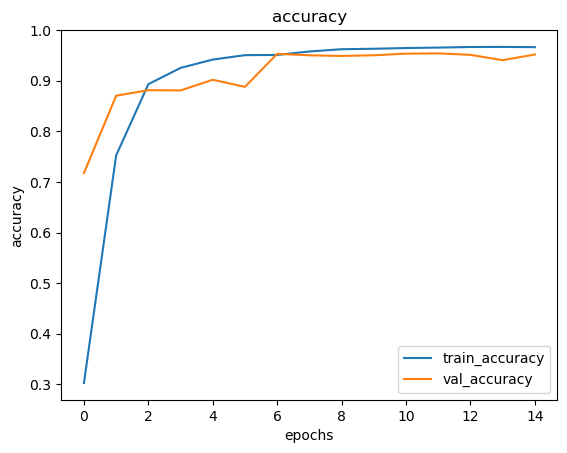

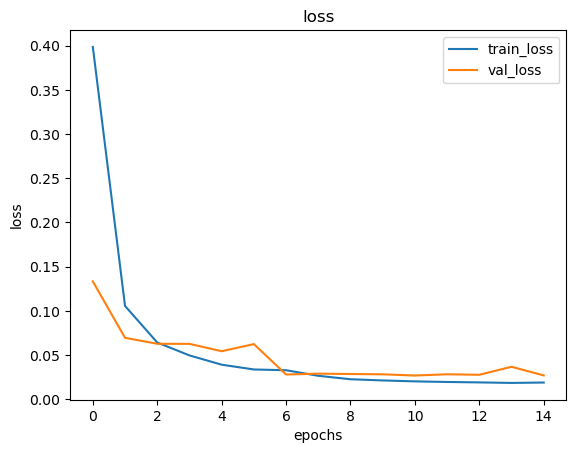

In [12]:
#plotting graphs

#model accuracy
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.show()

#model loss
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()
plt.show()







1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


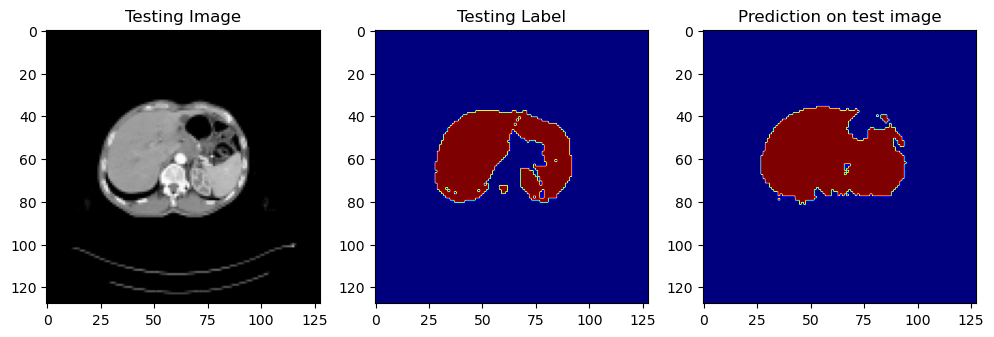

In [16]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()